# A TUTORIAL ON SUBSET SIMULATION WITH ADAPTIVE CONDITIONAL SAMPLING

by Sebastian T. Glavind, December 2022

In [1]:
import numpy as np
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
import SuStools as sust # import my subset simulation toolbox

print('Versions: numpy, ', np.__version__,'; scipy, ', scipy.__version__)

Versions: numpy,  1.23.3 ; scipy,  1.9.3


# Introduction

This tutorial introduces the subset simulation (SuS) algorithm for rare event sampling, which is an adaptive technique that is capable to handle high dimensional problems (Au & Beck, 2001; Au & Wang, 2014). SuS relies on Markov chain Monte Carlo (MCMC) simulation for efficiently generating conditional samples resulting in the targeted rare event, which we will refer to as the failure event. The primary property of the sample distribution resulting from MCMC simulation is that it either immediately resembles the target distribution, as for SuS, or converges to it as the Markov chain evolves, and thus statistical inferences made based on the sample distribution is asymptotically unbiased (Au & Wang, 2014). In SuS, the conditional samples immediately resemble the target distribution, as samples are drawn conditional on the failure event. We will use the efficient adaptive conditional sampling (aCS) algorithm of Papaioannou et al. (2015) as the MCMC engine, which operates in standard normal space. This, however, imposes no restricting on the applicability of the sampler, as any set of correlated random variables can be transformed to standard normal space using the probability integral transform. In engineering applications, the joint probability density function (PDF) is commonly modeled by a Gaussian copula (Nataf distribution), and thus the mapping to standard normal space is achieved through a marginal transformation.

***
Au, S., Beck, J. (2001). Estimation of small failure probabilities in high dimensions by subset simulation, Probabilistic Engineering Mechanics, 16, 263–277.

Au, S. K., & Wang, Y. (2014). Engineering risk assessment with subset simulation. John Wiley & Sons.

Papaioannou, I., Betz, W., Zwirglmaier, K., & Straub, D. (2015). MCMC algorithms for subset simulation. Probabilistic Engineering Mechanics, 41, 89-103.
***

# Subset simulation

We considere the probability of failure $P_F$, defined by the following M-fold integral:
$$
P_F = \int_{g(x) \leq 0} p_X(x) dx,
$$
where $X$ is a random vector of dimension M representing the system variables, $p_X(x)$ is the joint PDF of $X$, and $g(x) \leq 0$ defines failure of the system through the limit-state-function $g(x)$, which is a scalar function encoding one or several distinct failure modes. The basic idea of SuS is to compose a small probability $P_F$ into a product of larger conditional probabilities using the chain rule of probability theory. The failure region is thus defined as $F=\{x \in \mathbb{R}^M: g(x)\leq b\}$ for $b=0$. Thus, it may be expressed as the intersection of $J$ intermediate failure events $F_j$ as
$$
\begin{equation}
F=\bigcap_{j=1}^{J} F_j,\quad j=1,\dots,J
\end{equation}
$$
where intermediate failure events $F_j$, $j=1,\dots,J$ are sorted such that $F_1\supset F_2 \supset \cdots \supset F_J=F$ with associated intermediate threshold levels $b_j$ for which $b_1<b_2<\dots<b_J = b$. For this setting, the probability of failure $P_F$ may be expressed as 
$$
\begin{align}
P(F) &= P\left(\bigcap_{j=1}^{J} F_j\right) = P(F_1)\prod_{j=2}^{J}P(F_{j}|F_{j-1})
\end{align}
$$
The intermediate threshold levels $\{ b_j : j=2,\dots,J\}$ are chosen adaptively such that the conditional probabilities $\{ P(F_{j}|F_{j-1}): j=2,\dots,J\}$ and $P(F_1)$ are equal to a fixed value $p_0$. 

Now, SuS preceeds as follows: First, $P(F_1)$ is estimated using crude Monte Carlo simulating based on $N$ samples from $p_X(\cdot)$, where $N$ should be a value large enough to assess $p_0$ accurately. Second, we set the intermediate threshold level $b_1$ to the $p_0$-quantile of the reponses $\{g(x_n)\}_{n=1}^N$, which will define the failure region $F_1$ such that $P(F_1) = p_0$. Third, $P(F_2|F_1)$ is estimated using MCMC based on the seeds/particles $\{x: g(x) \leq b_1\}$ by constructing $N_c = N p_0$ Markov chains with $N_s = 1 / p_0$ states each. Here, we assume that $N p_0$ and $1 / p_0$ are interger values. Fourth, we set the intermediate threshold level $b_2$ to the $p_0$-quantile of the reponses $\{g(x_n)|F_1\}_{n=1}^N$, which will define the failure region $F_2$ such that $P(F_2) = p_0$. The process is continued until the failure region $F$ is reached, i.e. until $b_j$ exceeds the threshold level value $b=0$. By choosing, all intermediate threshold levels in this manner, the failure probability $P_F$ can be estimated as:
$$
\begin{equation}
P_F \approx p_0^{J-1}\frac{N_F}{N}
\end{equation}
$$
where $N_F$ is failure samples at level $J-1$ of SuS. Details on the algorithmitic implementation are given in Papaioannou et al. (2015; sec. 2) for the case of independent, standard normally distributed system variables. In my toolbox ``SuStools``, this function is called ``SuS_aCS``.

In [2]:
help(sust.SuS_aCS)

Help on function SuS_aCS in module SuStools:

SuS_aCS(N, M, g_func, p0=0.1, pa=0.1, std_opt=0, progress=0)
    -------------------------------------------------------------------------------------------------------
    Subset Simulation (standard Normal space) using adaptive conditional sampling (Papaioannou et al.,2015)
    (https://www.cee.ed.tum.de/era/software/reliability/subset-simulation/)
    NB! Failure is defined as g <= 0 (thus negative values), as in the paper.
    -------------------------------------------------------------------------------------------------------
    Input:
    * N - subset samples (N*p0 and 1/p0 must be positive integers) [scalar]
    * M - random variables/dimensions [scalar]
    * g_func - limit state function (possible transformations are conducted inside this object)
    * p0 - conditional probability of each subset (N*p0 and 1/p0 must be positive integers) [scalar]
    * pa - adaption ratio (default 0.1) [scaler]
    * std_opt - sigma options (0: c

# Adaptive conditional sampling

In the adaptive conditional sampling (aCS) algorithm of Papaioannou et al. (2015), as in any Markov chain, a proposal state $\mathbf{v} = \{ v_m \}_{m=1}^M$ is sampled conditional on a current state $\mathbf{u} = \{ u_m \}_{m=1}^M$. However, opposed to standard Metropolis-like samplers, a joint Gaussian distribution is imposed on $u$ and $v$ with component-wise cross-correlation coefficient $\rho_m$, whereby a close-form expression for the proposal distribution can be derived using the general rules for conditioning Gaussian random vectors, i.e., 
$$
v_m \sim \mathcal{N}( \rho_m u_m, \sqrt{1-\rho_m^2});
$$ 
thus $v_m$ forllows a Gaussian distribution with mean value $\mu_{m} = \rho_m u_m$ and standard deviation $\sigma_{m} = \sqrt{1-\rho_m^2}$. Note that it has been proven (Papaioannou et al.,2015; Au, 2016) that this procedure satisfies the detailed balance condition. 

The correlation coefficients $\{\rho_m\}_{m=1}^M$ are the tuning parameters of the algorithm, since they control the correlation and thus acceptance rate of the chains. When studying the efficiency of the algorithm, the mean acceptance rate $\hat{a}$ is introduced as the average number of accepted samples divided by the length of each chain. In terms of efficiency, the optimal value of the mean acceptance rate $a^*$ is arround 0.44 (Papaioannou et al.,2015). The aCS scheme, suggest to adapt the $\rho$-values within each level of SuS as follows: A fraction $N_a$ of the $N_s$ Markov chains are simulated. Then, the values $\{\sigma_m\}$ (or correspondingly $\{\rho_m\}$) are updated such that $\hat{a}$ becomes closer to the optimal value. This process is repeated through the $N_s/N_a$ iterations of one SuS level. At each iteration, the update of $\{\sigma_m\}$ are performed as 
$$
\sigma_{m,iter} = \lambda_{iter} \sigma_{0,m}
$$
where $\sigma_{0,m}$ is an initial scaling chosen by the user, and $\lambda_{iter}$ is a scaling factor defined as $\log \lambda_{iter+1} = \log \lambda_{iter} + iter^{-1/2} \left( \mathbb{E}_{iter}[\hat{a}] - a^* \right)$. Details on the algorithmitic implementation are given in Papaioannou et al. (2015; sec. 2) for the case of independent, standard normally distributed system variables. In my toolbox ``SuStools``, this function is called ``aCS``.

***
Au, S. (2016). On MCMC algorithm for subset simulation, Probabilistic Engineering Mechanics, 43, 117–120.
***

In [3]:
help(sust.aCS)

Help on function aCS in module SuStools:

aCS(N, lam0, b0, z0, g_func, pa=0.1, std_opt=0)
    ---------------------------------------------------------------------------
    Adaptive conditional sampling algorithm of Papaioannou et al. (2015)
    (https://www.cee.ed.tum.de/era/software/reliability/subset-simulation/)
    NB! Failure is defined as g <= 0 (thus negative values), as in the paper.
    ---------------------------------------------------------------------------
    Input:
    * N - subset samples (default 1000) [scalar]
    * lam0 - scaling parameter (e.g., 0.6; or from previous subset) [scalar]
    * b0 - intermediate threshold level (e.g., 10%-quantile) [scalar]
    * z0 - seeds used to generate the new samples (seeds corr. b0) [Nc x M array]
    * g_func - limit state function in z-space (limit state function) [func.]
    * pa - adaption ratio (default 0.1) [scaler]
    * std_opt - sigma options (0: constant 1; or 1: sample estimate) [0,1] 
    ---------------------------

# Numerical examples

In the following, we will solve some examples from Au & Wang (2014) and Papaioannou et al. (2015) to showcase how my toolbox can be used to perform subset simulation for rare event problems.

In [4]:
# limit state function
def g_p15_ex1(z):
    '''
    Example 1 from Papaioannou et al. (2015; sec. 4.1)
    '''
    beta = 3.719 # pf =~ 1e-4 (ss.norm().cdf(-3.719))
    return(-1/np.sqrt(len(z)) * np.sum(z) + beta)

def g_p15_ex2a(z):
    '''
    Example 2a from Papaioannou et al. (2015; sec. 4.2)
    '''
    lam_pam = 1
    Ca = 17.7820 # Corr. pf=1e-4 for M=5=len(z) (shape), lam_pam=1 (inverse scale), i.e., ss.gamma(a=M, scale=1/lam_pam).ppf(1-1e-4)
    # Ca = 141.53 # Corr. pf=1e-4 for M=100=len(z) (shape), lam_pam=1 (inverse scale), i.e., ss.gamma(a=M, scale=1/lam_pam).ppf(1-1e-4)
    u = ss.norm().cdf(z) # probability transform to u-space (uniform \in [0,1])
    x = ss.expon(scale = 1 / lam_pam).ppf(u) # probability transform to x-space (exponentially distribited variables with lam=1)
    return(Ca - sum(x)) # pf 1-ss.gamma(a=M, scale=1/lam_pam).cdf(Ca)

def g_p15_ex2b(z):
    '''
    Example 2a from Papaioannou et al. (2015; sec. 4.2)
    '''
    lam_pam = 1
    Cb = 0.44446 # Corr. pf=1e-4 for M=5=len(z) (shape), lam_pam=1 (inverse scale), i.e., ss.gamma(a=M, scale=1/lam_pam).ppf(1e-4)
    # Cb = 67.0077 # Corr. pf=1e-4 for M=100=len(z) (shape), lam_pam=1 (inverse scale), i.e., ss.gamma(a=M, scale=1/lam_pam).ppf(1e-4)
    u = ss.norm().cdf(z) # probability transform to u-space (uniform \in [0,1])
    x = ss.expon(scale = 1 / lam_pam).ppf(u) # probability transform to x-space (exponentially distribited variables with lam=1)
    return(-Cb + sum(x)) # pf ss.gamma(a=M, scale=1/lam_pam).cdf(Cb)

def g_a14_ex52(z):
    '''
    Example 5.2 from Au & Wang (2014; sec. 5.2)
    '''
    b = 7.221 # pf ~ 1e-4 # x_test = np.arange(0.05, 100.05, 0.1); 2*np.sum( ss.norm().cdf(-7.221/x_test) * ss.norm.pdf(x_test) ) * 0.1
    return(b - np.prod(z))

def g_a14_ex53(z):
    '''
    Example 5.3 (Brownian process) from Au & Wang (2014; sec. 5.2)
    '''
    dt = 1
    T = 100 # (=M)
    b = 38.905 # pf ~ 1e-4 # 2*ss.norm.cdf(-38.905/np.sqrt(100))
    return(b - np.max(np.cumsum(z)))

# # test
# test = np.random.normal(size=(10,100))
# g_ex1(test[0,:])

## First level of SuS with ``SuStools.aCS`` and ``SuStools.CoV2_subset`` for ``g_p15_ex1``

### Conditional sampling for first subset level with ``SuStools.aCS``

First thresshold level:  2.4149172310855245


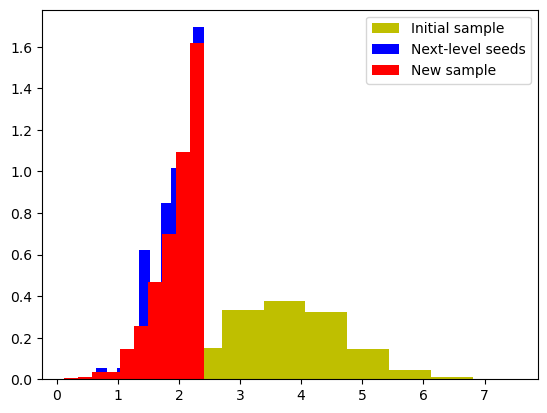

In [5]:
# test conditional sampler
np.random.seed(42)
N_test = 1000; M_test = 5; Nc_test = int(N_test*0.1)
z_test = np.random.normal(size=(N_test,M_test)); g_test = np.array([g_p15_ex1(z_test[i,:]) for i in range(z_test.shape[0])])
ids_test = np.argsort(g_test); z0_test = (z_test[ids_test, :])[:Nc_test, :]; g0_test = (g_test[ids_test])[:Nc_test]
b0_test = np.percentile(g_test[ids_test], 0.1*100)

z1_test, g1_test, lam1_test, sigma_test, acc_test = sust.aCS(N=N_test, lam0=1, b0=b0_test, z0 = z0_test, g_func = g_p15_ex1, pa=0.1, std_opt=0)
print('First thresshold level: ', b0_test); 
plt.hist(g_test, density=True, color='y'); plt.hist(g0_test, density=True, color='b'); plt.hist(g1_test, density=True, color='r')
plt.legend(['Initial sample', 'Next-level seeds', 'New sample'])
plt.show()

### Coefficient of variation for conditional probability estimate of first subset level with ``SuStools.CoV2_subset``

In [6]:
help(sust.CoV2_subset)

Help on function CoV2_subset in module SuStools:

CoV2_subset(g1, b1, Nc, Ns)
    ----------------------------------------------------------------------------------------------------
    Approximate, squared coefficient of variation for subset conditional probability, see e.g.,
    [1] Au & Beck (2001), Estimation of small failure probabilities in high dimensions by subset simulation
    [2] Zuev et al. (2012) - Bayesian Post-Processor and other Enhancements of Subset Simulation for 
    Estimating Failure Probabilities in High Dimensions
    ----------------------------------------------------------------------------------------------------
    Input:
    * g_val - limit state function evaluations (not sorted, i.e., grouped acc. to chains)
    * Nc - number of Markov chains (seeds)
    * Ns - number of samples simulated from each Markov chain (N/Nc)
    ----------------------------------------------------------------------------------------------------
    Output:
    * CoV - coeffiec

In [7]:
# test computation of coefficient of variation
print('CoV: ', np.sqrt( sust.CoV2_subset(g1_test, np.percentile(g1_test, 0.1*100), 100, 10)) ) # help(sust.CoV2_subset)

CoV:  0.10548065145319618


## Full SuS runs with ``SuStools.SuS_aCS`` for all examples

### SuS for ``g_p15_ex1`` ($P_f = 10^{-4}$)

In [8]:
np.random.seed(42)
res_p15_ex1 = sust.SuS_aCS(1000, 5, g_p15_ex1, p0=0.1, pa=0.1, std_opt=1, progress=1)


 Intermediate threshold level  0  =  2.4149172310855245
	*aCS lambda = 0.8187136048190462 	*aCS sigma = 0.7726794997384836 	*aCS acc = 0.475

 Intermediate threshold level  1  =  1.464003512658222
	*aCS lambda = 0.6747996394302772 	*aCS sigma = 0.6316085150825508 	*aCS acc = 0.42299999999999993

 Intermediate threshold level  2  =  0.6708543280618255
	*aCS lambda = 0.539662493452525 	*aCS sigma = 0.42247203864013505 	*aCS acc = 0.41

 Intermediate threshold level  3  =  0.075499928128409
	*aCS lambda = 0.4836044294614533 	*aCS sigma = 0.44352831883729743 	*aCS acc = 0.41900000000000004

 Intermediate threshold level  4  =  -0.5024166275754816
	*Pf = 7.570000000000002e-05 	*CoV = [  0.20671607611385578 ;  0.46171763188828163  ]


In [9]:
# Benchmark
np.random.seed(42)
pfs_p15_ex1 = list()
for t in range(100):
    if np.mod(t,10)==True:
        print('iteration: ', t-1, '/100')
    pfs_p15_ex1.append(sust.SuS_aCS(1000, 5, g_p15_ex1, p0=0.1, pa=0.1, std_opt=1, progress=0)[0])
    
print('Mean: ', np.mean(pfs_p15_ex1))
print('CoV: ', np.std(pfs_p15_ex1)/np.mean(pfs_p15_ex1))

iteration:  0 /100
iteration:  10 /100
iteration:  20 /100
iteration:  30 /100
iteration:  40 /100
iteration:  50 /100
iteration:  60 /100
iteration:  70 /100
iteration:  80 /100
iteration:  90 /100
Mean:  9.838700000000005e-05
CoV:  0.3109870250400605


### SuS for ``g_p15_ex2a`` ($P_f = 10^{-4}$)

In [10]:
np.random.seed(42)
res_p15_ex2a = sust.SuS_aCS(1000, 5, g_p15_ex2a, p0=0.1, pa=0.1, std_opt=1, progress=1)


 Intermediate threshold level  0  =  9.886478848071935
	*aCS lambda = 0.6885555146659218 	*aCS sigma = 0.7591126226305797 	*aCS acc = 0.45

 Intermediate threshold level  1  =  6.343657707018835
	*aCS lambda = 0.4761221468772211 	*aCS sigma = 0.5911463231145093 	*aCS acc = 0.398

 Intermediate threshold level  2  =  3.0296260395073804
	*aCS lambda = 0.3104480315029464 	*aCS sigma = 0.3806948781762093 	*aCS acc = 0.38199999999999995

 Intermediate threshold level  3  =  0.252642144718898
	*aCS lambda = 0.27447862519921407 	*aCS sigma = 0.41715152703104086 	*aCS acc = 0.418

 Intermediate threshold level  4  =  -2.4305611097348443
	*Pf = 7.930000000000003e-05 	*CoV = [  0.21457597817563182 ;  0.4788843716321281  ]


### SuS for ``g_p15_ex2b`` ($P_f = 10^{-4}$)

In [11]:
np.random.seed(42)
res_p15_ex2a = sust.SuS_aCS(1000, 5, g_p15_ex2b, p0=0.1, pa=0.1, std_opt=1, progress=1)


 Intermediate threshold level  0  =  1.9392476170295028
	*aCS lambda = 1.019826694511349 	*aCS sigma = 0.7634501749450396 	*aCS acc = 0.5229999999999999

 Intermediate threshold level  1  =  0.9051987501673623
	*aCS lambda = 0.8574853714588168 	*aCS sigma = 0.6543992471917266 	*aCS acc = 0.413

 Intermediate threshold level  2  =  0.34084651173925357
	*aCS lambda = 0.8195703716675922 	*aCS sigma = 0.4757110086837958 	*aCS acc = 0.442

 Intermediate threshold level  3  =  0.023775504336559894
	*aCS lambda = 0.6852936590192535 	*aCS sigma = 0.408438719104642 	*aCS acc = 0.41

 Intermediate threshold level  4  =  -0.13987705941563544
	*Pf = 7.320000000000002e-05 	*CoV = [  0.21203566128069057 ;  0.4729771156493787  ]


### SuS for ``g_a14_ex52`` ($P_f = 10^{-4}$)

In [12]:
np.random.seed(42)
res_a14_ex52 = sust.SuS_aCS(1000, 2, g_a14_ex52, p0=0.1, pa=0.1, std_opt=1, progress=1)


 Intermediate threshold level  0  =  6.155153554374246
	*aCS lambda = 0.48540308116612674 	*aCS sigma = 0.6913989545268165 	*aCS acc = 0.425

 Intermediate threshold level  1  =  4.109110760284805
	*aCS lambda = 0.25491057249514343 	*aCS sigma = 0.47581312597299386 	*aCS acc = 0.35

 Intermediate threshold level  2  =  1.7846448125414414
	*aCS lambda = 0.17627031865330123 	*aCS sigma = 0.40605791136769703 	*aCS acc = 0.395

 Intermediate threshold level  3  =  -0.06323996215604091
	*Pf = 0.00011300000000000004 	*CoV = [  0.19083952304623397 ;  0.38101662951706067  ]


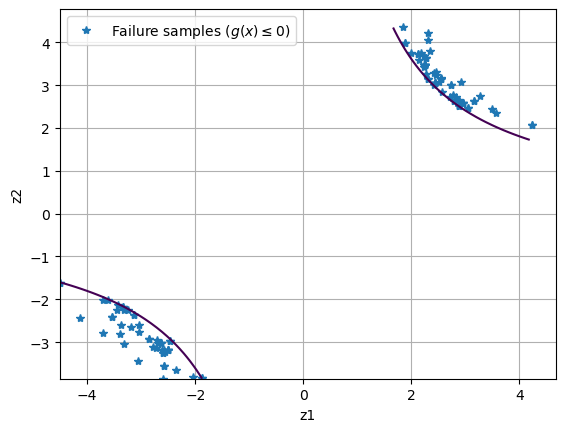

In [13]:
Z_a14_ex52_failure = res_a14_ex52[-2][-1][res_a14_ex52[-3][-1]<=0,:]
# plot failure samples
plt.plot(Z_a14_ex52_failure[:,0], Z_a14_ex52_failure[:,1], '*', label = 'Failure samples ($g(x) \leq 0$)')
# plot g(x) <= 0 conture
xx_a14_ex52, yy_a14_ex52 = np.meshgrid(np.arange(np.min(Z_a14_ex52_failure[:,0]), np.max(Z_a14_ex52_failure[:,0]), 0.1), 
                                       np.arange(np.min(Z_a14_ex52_failure[:,1]), np.max(Z_a14_ex52_failure[:,1]), 0.1))
zz_a14_ex52 = (7.221 - xx_a14_ex52 * yy_a14_ex52)
plt.contour(xx_a14_ex52, yy_a14_ex52, zz_a14_ex52, levels=np.array([0.0001]))
# define axis and legends
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
plt.grid()
plt.show()

### SuS for ``g_a14_ex53`` ($P_f = 10^{-4}$)

In [56]:
np.random.seed(42)
res_a14_ex53 = sust.SuS_aCS(1000, 100, g_a14_ex53, p0=0.1, pa=0.1, std_opt=1, progress=1)


 Intermediate threshold level  0  =  22.821199071475792
	*aCS lambda = 0.825243324447339 	*aCS sigma = 0.7999946999028524 	*aCS acc = 0.484

 Intermediate threshold level  1  =  12.631724245643786
	*aCS lambda = 0.5532549420068716 	*aCS sigma = 0.6661624132294728 	*aCS acc = 0.385

 Intermediate threshold level  2  =  6.28194968230051
	*aCS lambda = 0.4936085840226635 	*aCS sigma = 0.48391761029878927 	*aCS acc = 0.429

 Intermediate threshold level  3  =  0.6997747620949422
	*aCS lambda = 0.44495504078956055 	*aCS sigma = 0.4561071776651258 	*aCS acc = 0.42400000000000004

 Intermediate threshold level  4  =  -4.648536721470876
	*Pf = 8.020000000000002e-05 	*CoV = [  0.20832666655999657 ;  0.4652688776241354  ]
